# **Importar librerías**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# **Cargar datos**

In [62]:
train = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')
sample_submission = pd.read_csv('submission.csv')



# **Análisis exploratorio básico**

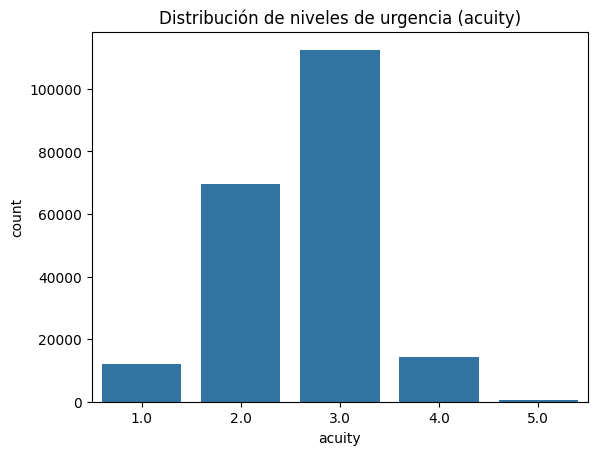

In [63]:
sns.countplot(x='acuity', data=train)
plt.title('Distribución de niveles de urgencia (acuity)')
plt.show()

# **Estadísticos básicos y chequeo valores nulos**

In [64]:
def conteoVal(df):
  for col in df.columns:
    print(col)
    print(df[col].value_counts())

print(train['pain'].value_counts())

pain
0                  70200
8                  20782
10                 20380
7                  15763
5                  14823
                   ...  
0sent  for  lab        1
moaning                1
pretty good            1
10/5                   1
0.3                    1
Name: count, Length: 565, dtype: int64


In [65]:
def getMediasFijas(df):
  mediasFijas = {}

  df = df.drop(columns=['pain'], errors='ignore')

  columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

  print(columnas_categoricas)

  for col in columnas_categoricas:
    mediasFijas[col] = df[col].mode()[0]

  for col in df.columns:
    if col not in columnas_categoricas:
      mediasFijas[col] = df[col].median()

  return mediasFijas


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re # Import the regular expression module

def clean_pain_column(value):
    if pd.isna(value):
        return np.nan

    # 1. Limpieza básica
    val = str(value).lower().strip().replace('"', '')

    # 2. Mapeo de términos comunes (Criterio clínico/subjetivo)
    mapping = {
        'no pain': 0, 'denies': 0, 'nad': 0, 'none': 0,
        'mild': 2, 'slight': 2, 'a little': 2, 'poquito': 2,
        'moderate': 5, 'some': 5, 'tolerable': 5,
        'severe': 8, 'bad': 8, 'mucho': 8, 'very bad': 9,
        'terrible': 10, 'horrible': 10, 'excrutiating': 10,
        'unable': np.nan, 'asleep': np.nan, 'unknown': np.nan, 'uta': np.nan
    }

    if val in mapping:
        return mapping[val]

    # 3. Manejo de rangos (ej. "7-8" -> 7.5)
    range_match = re.match(r'^(\d+)\s*-\s*(\d+)$', val)
    if range_match:
        start, end = map(float, range_match.groups())
        return (start + end) / 2

    # 4. Manejo de escalas (ej. "7/10" -> 7)
    scale_match = re.match(r'^(\d+)/10', val)
    if scale_match:
        return float(scale_match.group(1))

    # 5. Extraer el primer número que aparezca (para "10+", "8.5", "5 ")
    try:
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", val)
        if numbers:
            return float(numbers[0])
    except:
        pass

    return np.nan

def pipeline(df_input, mediasFijas=None, is_train=True, tfidf_obj=None):
    df = df_input.copy()

    ranges = {
    'temperature': (80.0, 110.0), # Asumiendo Fahrenheit predominante
    'heartrate':   (30.0, 220.0), # Desde bradicardia extrema a taquicardia máxima
    'resprate':    (8.0, 60.0),   # 1796.5 es claramente un error de entrada
    'o2sat':       (50.0, 100.0), # No puede existir saturación > 100%
    'sbp':         (50.0, 250.0), # Límites típicos de presión sistólica
    'dbp':         (30.0, 150.0)  # Límites típicos de presión diastólica
    }

    # Aplicamos el clip de forma masiva
    for col, (bajo, alto) in ranges.items():
        if col in df.columns:
            df[col] = df[col].clip(lower=bajo, upper=alto)

    mapping_disposition = {
    'LEFT WITHOUT BEING SEEN': 0, # Mínima intervención
    'ELOPED': 0,                  # Se fue sin aviso
    'LEFT AGAINST MEDICAL ADVICE': 1, # Se fue contra consejo médico
    'HOME': 2,                    # Alta estándar
    'OTHER': 2,                   # Otros (generalmente no críticos)
    'TRANSFER': 3,                # Necesita cuidados en otro centro
    'ADMITTED': 4,                # Ingreso hospitalario (Grave)
    'EXPIRED': 5                  # Fallecimiento (Máxima gravedad)
    }

    df['disposition'] = df['disposition'].map(mapping_disposition)

    # Convertimos intime y outtime con format='mixed' para manejar segundos ausentes
    df['intime'] = pd.to_datetime(df['intime'], format='mixed', errors='coerce')
    df['outtime'] = pd.to_datetime(df['outtime'], format='mixed', errors='coerce')

    df['pain'] = df['pain'].apply(clean_pain_column)

    # 1. Aseguramos que sea numérico y limitamos el rango de 0 a 10
    df['pain'] = pd.to_numeric(df['pain'], errors='coerce')
    df['pain'] = df['pain'].clip(lower=0, upper=10)

    # 2. Definimos los límites (bins) y las etiquetas (labels)
    # Los bins funcionan así: (-0.1 a 5], (5 a 8], (8 a 10]
    bins_pain = [-0.1, 5, 8, 10]
    labels_pain = [0, 1, 2] # 0: sin dolor, 1: con dolor, 2: extremo

    # 3. Creamos la nueva columna mapeada
    # Usamos .astype(float) primero si hay NaNs, o .astype(int) si prefieres números enteros
    df['pain_category'] = pd.cut(df['pain'], bins=bins_pain, labels=labels_pain).astype(float)

    df['no_pain'] = df['pain_category'].apply(lambda x: 1 if x == 0 else 0)

    df.drop(columns=['pain_category'], errors='ignore', inplace=True)

    df['heartrate_med_proxy'] = df['heartrate'] * df['medrecon_count']

    # Hipoxia Severa: < 90% | Hipoxia Leve: 90-94% | OK: 95-100%
    bins_o2 = [80, 89, 94, 100]
    labels_o2 = [-2, -1, 0]
    df['o2sat_status'] = pd.cut(df['o2sat'], bins=bins_o2, labels=labels_o2)

    # 1. Calculamos la diferencia numérica
    df['pulse_pressure'] = df['sbp'] - df['dbp']

    # 2. Categorizamos según rangos clínicos típicos:
    # Bajo (Narrow): < 25 mmHg (puede indicar fallo cardíaco o shock)
    # Normal: 30 - 60 mmHg
    # Alto (Wide): > 60 mmHg (indica rigidez arterial o problemas en válvulas)
    bins_pp = [0, 24, 60, 150]
    labels_pp = [-1, 0, 1]

    df['pulse_pressure'] = pd.cut(df['pulse_pressure'], bins=bins_pp, labels=labels_pp)

    #Si algo varia

    df['is_unstable'] = (
      (df['o2sat_status'] != 0) |
      (df['heartrate'] > 100) |
      (df['pulse_pressure'] != 0) |
      (df['resprate'] > 20)
    ).astype(int)

    # Mapeamos los valores string a valores numéricos
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    # 1. Definimos el diccionario con las prioridades que pediste
    mapping_transport = {
        'WALK IN': 0,
        'AMBULANCE': 1,
        'HELICOPTER': 2
    }

    # 2. Aplicamos el mapeo.
    # Los valores que no están en el diccionario (UNKNOWN y OTHER) se volverán NaN.
    # 3. Usamos .fillna(-1) para que "el resto" sea -1.
    df['arrival_transport'] = df['arrival_transport'].map(mapping_transport).fillna(-1).astype(int)

    # TF-IDF
    if is_train:
        tfidf_obj = TfidfVectorizer(max_features=210, stop_words='english')
        tfidf_matrix = tfidf_obj.fit_transform(df['chiefcomplaint'].fillna('none'))
    else:
        tfidf_matrix = tfidf_obj.transform(df['chiefcomplaint'].fillna('none'))

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_obj.get_feature_names_out(), index=df.index)

    # 2. Identificamos columnas que ya existen en el df original
    columnas_duplicadas = [col for col in tfidf_df.columns if col in df.columns]

    # 3. Borramos del tfidf_df esas columnas para que no "pisen" nada
    tfidf_df = tfidf_df.drop(columns=columnas_duplicadas)

    df = pd.concat([df, tfidf_df], axis=1)

    # Nivel 1 (Emergencia extrema)
    emergencias = ['trauma', 'gunshot', 'stroke']

    patronEmer = '|'.join(emergencias)

    # Cuenta cuántas veces aparecen las palabras del patrón en el texto
    df['is_emergency'] = (df['chiefcomplaint'].str.lower().str.count(patronEmer).fillna(0) != 0)

    #Detectar si es algo periodico leve nivel 5
    checkeos= ['refill','check','removal','eval']
    patronCheckeo = '|'.join(checkeos)
    df['is_periodic_check'] = (df['chiefcomplaint'].str.lower().str.contains(patronCheckeo).fillna(0) != 0)

    df['is_healthy'] = (
        (df['o2sat_status'] == 0) &               # Oxígeno normal (95-100%)
        (df['pulse_pressure'] == 0) &            # Presión de pulso normal (25-60 mmHg)
        (df['heartrate'] >= 60) & (df['heartrate'] <= 100) & # Pulso en rango normal
        (df['resprate'] >= 12) & (df['resprate'] <= 20) &   # Respiración en rango normal
        (df['no_pain'] == 1) &                   # Sin dolor
        (df['arrival_transport'] == 0)           # Llegó por su cuenta (WALK IN)
    ).astype(int)

    #La mayoria de valores de acuity 5 presentan sin dolor llegaron a pie y se fueron a casa aumenta la probabilidad de que sea una revision periodica
    df['periodic_check_points'] = df['is_periodic_check'] + df['no_pain'] + (df['arrival_transport'] == 0) + (df['disposition'] == 2) + df['is_healthy']

    df['no_meds'] = df['pyxis_count'] == 0

    # Corrected the boolean operation with parentheses
    df['has_anestesics'] = (df['no_meds'] == 0) & (df['no_pain'] == 1)

    # Sanitize column names for LightGBM
    def sanitize_col_names(df_to_sanitize):
        cols = df_to_sanitize.columns
        new_cols = []
        for col in cols:
            new_col = re.sub(r'[^A-Za-z0-9_]+', '', str(col)) # Remove non-alphanumeric/underscore
            new_cols.append(new_col)
        df_to_sanitize.columns = new_cols
        return df_to_sanitize

    df = sanitize_col_names(df)

    # Definimos pesos por síntoma
    pesos = {
        'chest': 3,   # Muy grave
        'breath': 3,  # Muy grave
        'dyspnea': 3, # Muy grave
        'suicidal': 2,# Grave
        'abdominal': 1, # Moderado
        'fever': 1     # Moderado
    }

    def calcular_gravedad(texto):
        texto = str(texto).lower()
        score = 0
        for palabra, valor in pesos.items():
            if palabra in texto:
                score += valor
        return score

    # Creamos una única columna numérica
    df['chiefcomplaint'] = df['chiefcomplaint'].apply(calcular_gravedad)

    df['shock_index'] = df['heartrate'] / df['sbp']

    df.drop(columns=['intime', 'outtime', 'race'], errors='ignore', inplace=True)

    if is_train:
      mediasFijas = getMediasFijas(df)

    df = df.fillna(mediasFijas)

    # Esto mantiene solo la primera aparición de cada nombre de columna
    df = df.loc[:, ~df.columns.duplicated()]

    return df, tfidf_obj, mediasFijas

# **Entrenando al modelo**

### **Codificar género**

In [67]:
trainPipe, tfidf_obj, mediasFijas = pipeline(train)
X_test_final, _, _= pipeline(test, is_train=False, tfidf_obj=tfidf_obj, mediasFijas=mediasFijas)

['o2sat_status', 'pulse_pressure']


In [68]:
# Convert categorical columns to integers for XGBoost compatibility
categorical_cols_to_convert = [
  'temperature_status', 'o2sat_status',
  'pulse_pressure', 'med_complexity_status', 'treatment_intensity_status',
  'monitoring_status'
]

for col in categorical_cols_to_convert:
    if col in trainPipe.columns:
      trainPipe[col] = trainPipe[col].astype(int)

# 'X' contiene los datos clínicos (quitamos el ID y el objetivo)
X = trainPipe.drop(columns=['acuity', 'stay_id'], errors='ignore')

# 'y' es lo que queremos predecir
# Adjust acuity to be 0-indexed for XGBoost compatibility
y = trainPipe['acuity'] - 1

print(trainPipe.columns.shape)

(237,)


In [69]:
# Usamos stratify=y para que ambos grupos tengan la misma proporción de urgencias
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

'''
lgbm = LGBMClassifier(
    n_estimators=256,
    learning_rate=0.1,
    class_weight='balanced',
    importance_type='gain'
    )

# 2. Entrenamos LightGBM (él ya usa su propio class_weight='balanced')
print("Entrenando LightGBM...")
lgbm.fit(X_train, y_train)
scores = cross_val_score(lgbm, X, y, cv=5, scoring='f1_macro')
'''

'\nlgbm = LGBMClassifier(\n    n_estimators=256,\n    learning_rate=0.1,\n    class_weight=\'balanced\',\n    importance_type=\'gain\'\n    )\n\n# 2. Entrenamos LightGBM (él ya usa su propio class_weight=\'balanced\')\nprint("Entrenando LightGBM...")\nlgbm.fit(X_train, y_train)\nscores = cross_val_score(lgbm, X, y, cv=5, scoring=\'f1_macro\')\n'

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 1. Configuración inicial
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
test_probs = np.zeros((len(X_test_final), 5)) 
val_scores = []
all_y_true = []
all_y_pred = []

# --- PARÁMETRO CLAVE ---
multiplicador_5 = 2.6 # Ajusta este valor (ej. 2.0, 3.0, 5.0) para "empujar" el Acuity 5
# -----------------------

# Alineación de columnas y tipos
X_test_final = X_test_final[X.columns]
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_final = X_test_final.apply(pd.to_numeric, errors='coerce').fillna(0)

print(f"Iniciando entrenamiento con Multiplicador x{multiplicador_5}...")

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"--- Entrenando Fold {i+1} ---")

    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Modelo con pesos balanceados
    model = LGBMClassifier(
        n_estimators=256,
        learning_rate=0.04,
        class_weight='balanced',
        importance_type='gain',
        random_state=42
    )

    model.fit(X_train_fold, y_train_fold)

    # --- VALIDACIÓN CON AJUSTE ---
    # Obtenemos probabilidades
    v_probs = model.predict_proba(X_val_fold)
    # Aplicamos el bono a la clase 5 (índice 4)
    v_probs[:, 4] *= multiplicador_5 
    # Decidimos la clase ganadora
    y_pred_val = np.argmax(v_probs, axis=1)

    # Guardar para el reporte final
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred_val)
    
    score = accuracy_score(y_val_fold, y_pred_val)
    val_scores.append(score)
    print(f"Accuracy Fold {i+1}: {score:.4f}")

    # --- ACUMULACIÓN PARA TEST ---
    # Guardamos probabilidades puras (el ajuste se hace al final de todo)
    test_probs += model.predict_proba(X_test_final) / 5

# --- PROCESO FINAL FUERA DEL BUCLE ---

# Aplicar el multiplicador al promedio de los 5 modelos
test_probs[:, 4] *= multiplicador_5
final_predictions = np.argmax(test_probs, axis=1) + 1

print("\n" + "="*50)
print(f"REPORTE GLOBAL (Multiplicador: {multiplicador_5})")
print("="*50)

print(classification_report(
    all_y_true, 
    all_y_pred, 
    target_names=['Acuity 1', 'Acuity 2', 'Acuity 3', 'Acuity 4', 'Acuity 5']
))

print("\nMatriz de Confusión Global:")
print(confusion_matrix(all_y_true, all_y_pred))

print(f"\nAccuracy Promedio Final: {np.mean(val_scores):.4f}")

Iniciando entrenamiento con Multiplicador x2.6...
--- Entrenando Fold 1 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16614
[LightGBM] [Info] Number of data points in the train set: 167240, number of used features: 235
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Accuracy Fold 1: 0.5922
--- Entrenando Fold 2 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

In [72]:
'''from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Obtener predicciones de validación (no de test, para poder comparar)
# Asumiendo que guardaste un set de validación X_val, y_val
y_val_pred = lgbm.predict(X_val)

# 2. Crear la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# 3. Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de Confusión: Niveles de Acuity (Triaje)')
plt.ylabel('Realidad (Acuity Real)')
plt.xlabel('Predicción (Acuity Predicho)')
plt.show()

# 4. Mostrar métricas por cada nivel
print(classification_report(y_val, y_val_pred))

f1_local = f1_score(y_val, y_val_pred, average='weighted')
print(f"F1 Score (Local): {f1_local}")'''

'from sklearn.metrics import confusion_matrix, classification_report\nimport matplotlib.pyplot as plt\n\n# 1. Obtener predicciones de validación (no de test, para poder comparar)\n# Asumiendo que guardaste un set de validación X_val, y_val\ny_val_pred = lgbm.predict(X_val)\n\n# 2. Crear la matriz de confusión\ncm = confusion_matrix(y_val, y_val_pred)\n\n# 3. Visualizar\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'YlGnBu\',\n            xticklabels=[1, 2, 3, 4, 5],\n            yticklabels=[1, 2, 3, 4, 5])\nplt.title(\'Matriz de Confusión: Niveles de Acuity (Triaje)\')\nplt.ylabel(\'Realidad (Acuity Real)\')\nplt.xlabel(\'Predicción (Acuity Predicho)\')\nplt.show()\n\n# 4. Mostrar métricas por cada nivel\nprint(classification_report(y_val, y_val_pred))\n\nf1_local = f1_score(y_val, y_val_pred, average=\'weighted\')\nprint(f"F1 Score (Local): {f1_local}")'

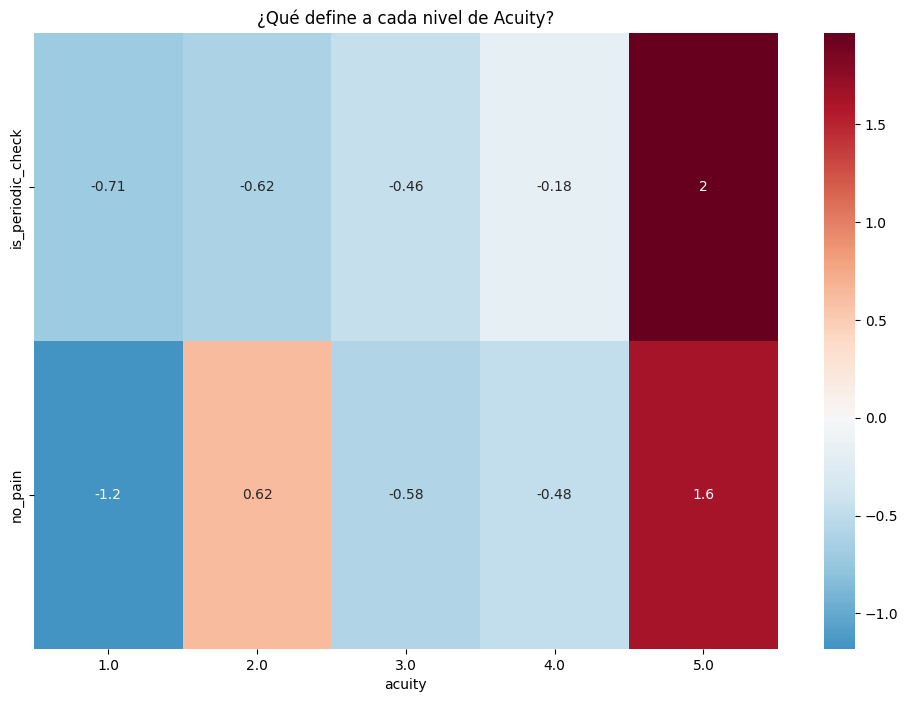

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Seleccionar columnas numéricas (excluyendo IDs)
cols_clinicas = ['is_periodic_check','no_pain']

# 2. Calcular el promedio por nivel
df_profile = trainPipe.groupby('acuity')[cols_clinicas].mean()

# 3. Estandarizar para que sean comparables
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_profile),
                         columns=df_profile.columns,
                         index=df_profile.index)

# 4. Graficar Heatmap0
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.T, annot=True, cmap='RdBu_r', center=0)
plt.title('¿Qué define a cada nivel de Acuity?')
plt.show()

In [74]:
'''# 1. Extraer importancias y crear un DataFrame
importancias = pd.DataFrame({
    'columna': X_train.columns,
    'importancia': lgbm.feature_importances_
}).sort_values(by='importancia', ascending=False)

# 2. Ver las 10 mejores (las que más ayudan)
print("--- TOP 10 VARIABLES ---")
print(importancias.head(25))

# 3. Ver las candidatas a ser borradas (las que menos ayudan)
print("\n--- VARIABLES MENOS IMPORTANTES ---")
ceros = importancias[importancias['importancia'] == 0]
print(importancias.tail(25))

print(importancias[importancias['columna']=='is_periodic_check'])

# 4. Contar cuántas tienen importancia CERO
print(f"\nHay {len(ceros)} columnas con importancia 0 (Inútiles).")'''

'# 1. Extraer importancias y crear un DataFrame\nimportancias = pd.DataFrame({\n    \'columna\': X_train.columns,\n    \'importancia\': lgbm.feature_importances_\n}).sort_values(by=\'importancia\', ascending=False)\n\n# 2. Ver las 10 mejores (las que más ayudan)\nprint("--- TOP 10 VARIABLES ---")\nprint(importancias.head(25))\n\n# 3. Ver las candidatas a ser borradas (las que menos ayudan)\nprint("\n--- VARIABLES MENOS IMPORTANTES ---")\nceros = importancias[importancias[\'importancia\'] == 0]\nprint(importancias.tail(25))\n\nprint(importancias[importancias[\'columna\']==\'is_periodic_check\'])\n\n# 4. Contar cuántas tienen importancia CERO\nprint(f"\nHay {len(ceros)} columnas con importancia 0 (Inútiles).")'

In [75]:
print(trainPipe.columns.shape)

# Convert categorical columns to integers for consistency with training data
categorical_cols_to_convert = [
    'temperature_status', 'resprate_status', 'o2sat_status',
    'pulse_pressure', 'med_complexity_status', 'treatment_intensity_status',
    'monitoring_status'
]

for col in categorical_cols_to_convert:
    if col in X_test_final.columns:
        X_test_final[col] = X_test_final[col].astype(int)

# 2. Asegurar que las columnas coinciden con el entrenamiento
X_test_final = X_test_final[X.columns.drop('acuity', errors='ignore')]

# 3. Realizar la predicción con tu mejor modelo
predicciones = np.argmax(test_probs, axis=1)

# 4. Crear el DataFrame de entrega
submission = pd.DataFrame({
    'stay_id': test['stay_id'],
    'acuity': predicciones.astype(int) # Kaggle requiere que sean enteros
})

submission['acuity'] = submission['acuity'] + 1 # Vuelve a 1-indexar

# 5. Guardar el archivo
submission.to_csv('submission_final.csv', index=False)

(237,)
